# 1 - Introduction

### What is OSMnx?

> A __Python package__ to download administrative boundary shapes and street networks from OSM.
>It is built over 
>###  *Networkx     +     Geopandas     +     Matplotlib*
>allowing for basic and extended __spatial statistical analysis and visualization__

>### *R-tree*
>allowing __fast__ spatial queries

### And what makes it special?

> __Automated downloading__ of boundary shapes, streets and building footprint

> Ability to extract it in __3 different formats__

### Cool! Let's see it in action ..

In [1]:
import osmnx as ox
import geopandas as gpd
#import urllib3

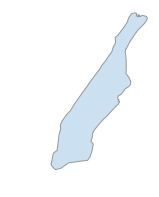

In [2]:
# get the boundary polygon for manhattan, save it as a shapefile, project it to UTM, and plot it
city = ox.gdf_from_place('Manhattan, New York City, New York, USA')
ox.save_gdf_shapefile(city)
fig, ax = ox.plot_shape(city, figsize=(3,3))

### This could be a county, city, state, country, continent or even a list of multiple places

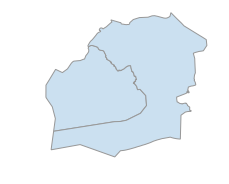

In [5]:
place_names = ['Brooklyn, New York City, New York, USA', 'Queens, New York City, New York, USA']
nyc = ox.gdf_from_places(place_names)
fig, ax = ox.plot_shape(nyc, figsize=(3,3))

### Moving to streets..


Street networks can be downloaded by providing either
* A bounding box
* A lat-lon with distance
* Name(s) of place
* Address of place with distance
* Polygon for streets within

Street networks can be filtered for the following types
* 'drive'
* 'service'
* 'bike'
* 'walk'
* 'all' - default
* 'all_private'

#### A graph of street network for Brooklyn

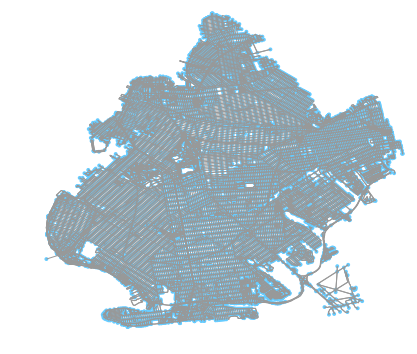

(<matplotlib.figure.Figure at 0x7fe435aa85d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe435aa8d50>)

In [7]:
G1 = ox.graph_from_place('Brooklyn, USA')
ox.plot_graph(G1)

#### A graph for driveable streets within a 1000 m radius around Carto (by Address)

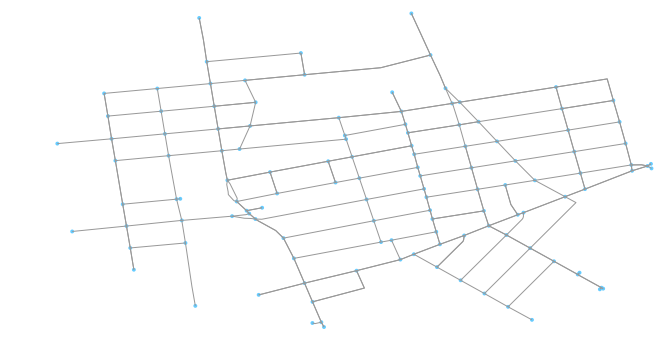

(<matplotlib.figure.Figure at 0x7fe4362ba590>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe432e39ed0>)

In [10]:
G2 = ox.graph_from_address('201 Moore St, Brooklyn, NY', distance=1000, distance_type='network', network_type='drive')
ox.plot_graph(G2)

#### A graph for driveable streets within a 1000 m radius around Carto (by lat lon)

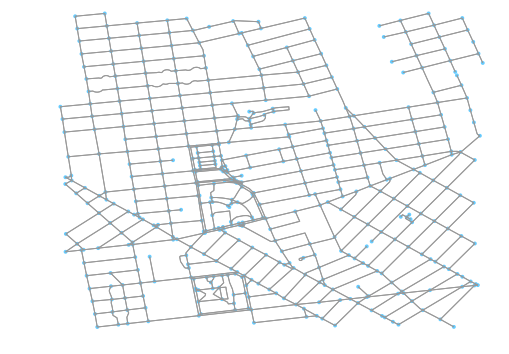

(<matplotlib.figure.Figure at 0x7fe435f1b650>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe42ebcead0>)

In [11]:
G3 = ox.graph_from_point((40.704667, -73.936701), distance=1000, network_type='walk')
ox.plot_graph(G3)

### Can I save these graphs for later use?

There are 3 different file formats to save these graphs
* Shapefile
* GraphML file (to use in Gephi or NetworkX)
* SVG (to use in Illustrator)